# Imports

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge,Lasso
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt

# DataSet1

Loading

In [22]:
diabetes = datasets.load_diabetes()

Defining Features and Target

In [23]:
X = diabetes.data
y = diabetes.target

Data Splitting for Testing and Training

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=0)

# Ridge

Implmentation

In [6]:
class RidgeRegression:
    def __init__(self, regulizer=1.0):
        self.regulizer = regulizer  # Regularization strength
        self.coffs = None  # Model Weights
        self.b = None  # b term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        X_augmented = np.hstack([np.ones((n_samples, 1)), X])    # Augmentation (1's Column)

        I = np.eye(X_augmented.shape[1])
        I[0, 0] = 0  # for not regulizing b

        XtX = np.dot(X_augmented.T, X_augmented)  # XT * X
        XtY = np.dot(X_augmented.T, y)  # XT * y

        XtX_reg = XtX + self.regulizer * I      # XTX+λI

        XtX_reg_inv = np.linalg.inv(XtX_reg)    # (XTX+λI)^−1
        coffs = np.dot(XtX_reg_inv, XtY)        # W=(XTX+λI)^−1 XTy

        self.b = coffs[0]  # The first value is the b
        self.coffs = coffs[1:]  # The rest are the Weights


    def predict(self, X):
        #------np.dot(----------------Augmented X--------,-------b added to W in one vecto----)----
        return np.dot(np.hstack([np.ones((X.shape[0], 1)), X]), np.hstack([self.b, self.coffs]))   #y^=X⋅W




Performance

In [7]:
ridge_custom = RidgeRegression(regulizer=1.0)
ridge_custom.fit(X_train, y_train)

y_pred_custom = ridge_custom.predict(X_test)
mse_custom = mean_squared_error(y_test, y_pred_custom)
print("Custom Ridge Regression MSE:", mse_custom)

ridge_sklearn = Ridge(alpha=1.0)
ridge_sklearn.fit(X_train, y_train)
y_pred_sklearn = ridge_sklearn.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
print("Scikit-learn Ridge Regression MSE:", mse_sklearn)

print("Custom Coefficients:", ridge_custom.coffs)
print("Scikit-learn Coefficients:", ridge_sklearn.coef_)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_custom_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_custom = RidgeRegression(regulizer=1.0)
    ridge_custom.fit(X_train, y_train)
    y_pred_custom = ridge_custom.predict(X_test)

    mse_custom = mean_squared_error(y_test, y_pred_custom)
    mse_custom_scores.append(mse_custom)

mean_mse_custom = np.mean(mse_custom_scores)

print("Custom Ridge Regression Mean MSE with Cross-Validation:", mean_mse_custom)


Custom Ridge Regression MSE: 3379.4063076042657
Scikit-learn Ridge Regression MSE: 3379.4063076042657
Custom Coefficients: [  21.34794489  -72.97401935  301.36593604  177.49036347    2.82093648
  -35.27784862 -155.52090285  118.33395129  257.37783937  102.22540041]
Scikit-learn Coefficients: [  21.34794489  -72.97401935  301.36593604  177.49036347    2.82093648
  -35.27784862 -155.52090285  118.33395129  257.37783937  102.22540041]
Custom Ridge Regression Mean MSE with Cross-Validation: 3433.171835094969


Performance for sklearn Model

In [8]:
mse_sklearn_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_sklearn = Ridge(alpha=1.0)
    ridge_sklearn.fit(X_train, y_train)
    y_pred_sklearn = ridge_sklearn.predict(X_test)

    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    mse_sklearn_scores.append(mse_sklearn)

mean_mse_sklearn = np.mean(mse_sklearn_scores)
print("Scikit-learn Ridge Regression Mean MSE with Cross-Validation:", mean_mse_sklearn)

Scikit-learn Ridge Regression Mean MSE with Cross-Validation: 3433.171835094969


Visualize

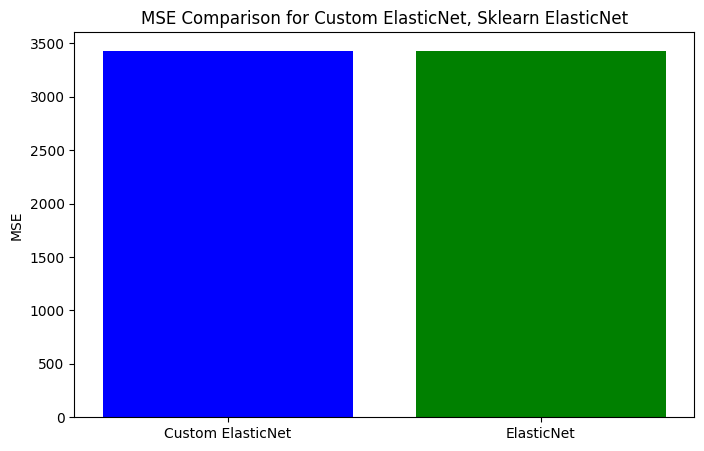

In [9]:
plt.figure(figsize=(8, 5))
plt.bar(['Custom ElasticNet','ElasticNet'], [mean_mse_custom,mean_mse_sklearn], color=['blue', 'green'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom ElasticNet, Sklearn ElasticNet')
plt.show()

# Lasso

Implementation

In [13]:
class LassoRegression:
    """
    Lasso Regression using L1 regularization.
    """

    class l1_regularization:
        """L1 Regularization for Lasso Regression"""

        def __init__(self, lamda):
            self.lamda = lamda

        def __call__(self, w):
            """L1 regularization term."""
            return self.lamda * np.sum(np.abs(w))

        def derivation(self, w):
            """Derivative of L1 regularization."""
            return self.lamda * np.sign(w)

    def __init__(self, lamda=0.01, lr=0.01, itr=1000, tolerance=1e-6):
        """
        lamda: Regularization factor
        lr: Learning rate
        itr: Maximum number of iterations
        tolerance: Convergence threshold for cost change
        """
        self.regularization = self.l1_regularization(lamda)
        self.lr = lr
        self.itr = itr
        self.tolerance = tolerance
        self.m = None  # number of training samples
        self.n = None  # number of features
        self.w = None  # weights
        self.b = None  # bias

    def cost_function(self, y, y_pred):
        """Calculate the cost function J(w) with L1 regularization."""
        mse = (1 / (2 * self.m)) * np.sum(np.square(y_pred - y))
        reg_term = self.regularization(self.w)
        return mse + reg_term

    def hypothesis(self, w, b, X):
        """Predict target values using the linear hypothesis."""
        return np.dot(X, w) + b

    def train(self, X, y):
        """Train the model using gradient descent."""

        # Ensure y is a column vector (n, 1)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        self.m, self.n = X.shape

        if self.m == 0:
            raise ValueError(
                "Number of training samples (m) is zero, which will cause division by zero.")

        # Initialize weights and bias
        self.w = np.zeros((self.n, 1))
        self.b = 0

        previous_cost = float('inf')  # To check convergence

        for it in range(1, self.itr + 1):
            # 1. Calculate predictions
            y_pred = self.hypothesis(self.w, self.b, X)

            # 2. Calculate the cost
            cost = self.cost_function(y, y_pred)

            # 3. Calculate gradients for w and b
            dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
            # L1 regularization on weights only (exclude bias)
            dw += self.regularization.derivation(self.w)

            db = (1 / self.m) * np.sum(y_pred - y)  # Gradient for the bias

            # 4. Update weights and bias using gradient descent
            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db

            # 5. Convergence check
            if abs(previous_cost - cost) < self.tolerance:
                logging.info(f"Convergence reached at iteration {it} with cost {cost:.6f}")
                break

            previous_cost = cost

            # Logging for every 100 iterations
            # if it % 100 == 0:
            #     logging.info(f"Iteration {it} | Cost: {cost:.6f}")

    def predict(self, X):
        """Predict the target values for the given input features."""
        y_pred = self.hypothesis(self.w, self.b, X)
        return y_pred

Y to 1-D instaed of 2-D

In [14]:
Y = y[:, np.newaxis]
print("="*100)
print("Number of training data samples-----> {}".format(X.shape[0]))
print("Number of training features --------> {}".format(X.shape[1]))
print("Shape of the target value ----------> {}".format(y.shape))

Number of training data samples-----> 442
Number of training features --------> 10
Shape of the target value ----------> (442,)


Performance of custom Lasso

In [15]:
lasso_model = LassoRegression(lamda=1, lr=0.01, itr=10000)
lasso_model.train(X_train, y_train)
y_pred = lasso_model.predict(X_test)
print(y_pred.flatten())

[168.10887135 169.51352305 154.26957654 143.3014477  152.57406781
 169.50310358 140.80626853 160.99148842 146.51000347 162.63586107
 148.42592854 161.93837552 141.87426271 135.33609006 173.78873666
 139.67458145 146.27818023 131.64756711 133.4101059  164.70927919
 155.14440672 149.10668229 153.7750382  146.47157647 165.52839409
 154.90218604 141.02800851 135.31862617 154.45078345 157.31882635
 158.12903059 134.8813077  144.60995921 150.59915133 154.07135909
 157.29569839 153.63407454 159.6244199  145.80864282 160.9278502
 137.2168649  158.03009515 151.95417925 153.43719743 160.33521702
 133.5514134  146.54969192 147.29239903 150.4195619  165.08897254
 151.59806031 137.19487715 149.10476107 155.89907771 164.1269963
 161.67508083 161.63477747 138.49619874 151.75607504 158.76543489
 159.2183805  150.1776376  153.7870454  148.23897843 169.66661216
 149.73105712 135.33127235 170.97410421 166.09706166 131.89901976
 134.39774178 152.42298404 144.59082651 146.48081339 147.04588385
 161.1693425

In [16]:
model = Lasso(alpha=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[196.06915657 200.37220201 149.4164878  129.31375659 158.90084765
 212.51348311 129.70449222 174.5846108  149.09961684 192.35581107
 142.59757187 173.06625567 126.17197144 115.67923848 198.06761992
 118.40888575 128.37687532 107.76747917  96.34504789 167.82137554
 153.10744239 162.14365074 150.83402606 158.51105293 195.14193663
 171.59967425 130.4168034  119.09716969 163.41053135 165.76386
 160.1045647  107.32591407 133.2272528  149.49818308 160.26651667
 164.86452983 150.10625809 151.72359603 137.12306269 176.18668968
 114.69127891 154.51641021 163.53542656 162.3721378  156.3833375
 107.89703119 150.02555483 148.26885356 141.74500756 174.67854132
 143.67881764 111.3582612  140.01689147 158.54177212 183.91732433
 156.63179153 175.4855262  132.90027728 146.7661563  172.21156402
 180.10697338 156.31100694 154.45329107 138.80654025 211.80464233
 161.73552537 114.3081728  186.60198871 185.10984258 120.53863632
 117.08419046 154.32716168 140.87351939 158.25561701 138.88932308
 156.09872319 

Testing diffrent lambdas

In [17]:
lambdas = [0.001, 0.01, 0.1, 1, 10]
k_folds = 10 # Number of folds for cross-validation
lambda_mse_scores = {}

for lamda in lambdas:
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = LassoRegression(lamda=lamda, lr=0.01, itr=100)
        model.train(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        mse = np.mean((y_val_pred - y_val_fold) ** 2)
        mse_scores.append(mse)

    lambda_mse_scores[lamda] = np.mean(mse_scores)

best_lambda = min(lambda_mse_scores, key=lambda x: lambda_mse_scores[x])
print(f"Best Lambda from Cross-Validation: {best_lambda}")

Best Lambda from Cross-Validation: 0.001


Fitting with the est fucking lambda

In [18]:
# Train the final custom Lasso model with the best lambda
final_custom_model = LassoRegression(lamda=best_lambda, lr=0.01, itr=1000)
final_custom_model.train(X_train, y_train)
final_custom_y_pred = final_custom_model.predict(X_test)
print(final_custom_y_pred.flatten())

[155.87625008 156.59902401 152.6693698  149.0698631  150.92548464
 155.54778911 148.20216878 154.86613401 148.57914136 153.22437311
 149.62896873 155.37987474 148.23008649 145.84827132 159.14276719
 147.53360361 149.53865865 145.25847237 145.06048528 156.81571254
 151.36051766 149.64324826 152.61934436 148.33225472 155.12058135
 152.6517398  148.68671925 146.49994626 151.96826481 153.64923665
 154.419596   146.39707964 148.41997056 151.11857727 153.90196647
 153.21656743 152.58456148 154.59273561 150.27977339 154.52878015
 147.54252997 154.23916438 152.21791845 151.60994897 155.1211995
 146.48524259 149.92351612 149.92194198 152.23462316 156.11349661
 151.40285122 147.0997559  150.96088042 153.44443373 154.83248316
 155.90461884 155.23027099 145.84883352 153.55826123 154.34253784
 152.48362674 150.21249809 152.70883086 151.66823418 155.73816589
 150.0880281  146.54935255 158.39115091 155.64978206 145.72516394
 146.15333988 153.03821412 149.50322229 149.22922223 149.57432975
 154.984888

Scikitlearn Model Performance

In [19]:
# --- Scikit-learn Lasso Model with Cross-Validation ---
param_grid = {'alpha': lambdas}
grid_search = GridSearchCV(
    Lasso(max_iter=1000), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha from Scikit-learn GridSearchCV: {best_alpha}")


final_sklearn_model = Lasso(alpha=best_alpha, max_iter=1000)
final_sklearn_model.fit(X_train, y_train)
final_sklearn_y_pred = final_sklearn_model.predict(X_test)

Best Alpha from Scikit-learn GridSearchCV: 0.01


MSEs for the two models

In [20]:
mse_custom = np.mean((final_custom_y_pred - y_test) ** 2)
mse_sklearn = np.mean((final_sklearn_y_pred - y_test) ** 2)
mse_cross_val_best = lambda_mse_scores[best_lambda]

print(f"MSE (Custom Lasso): {mse_custom}")
print(f"MSE (Scikit-learn Lasso): {mse_sklearn}")
print(f"MSE (Cross-Validated Best Lambda): {mse_cross_val_best}")

MSE (Custom Lasso): 5146.684676436087
MSE (Scikit-learn Lasso): 3445.806809246601
MSE (Cross-Validated Best Lambda): 9232.03198689884


Visualize

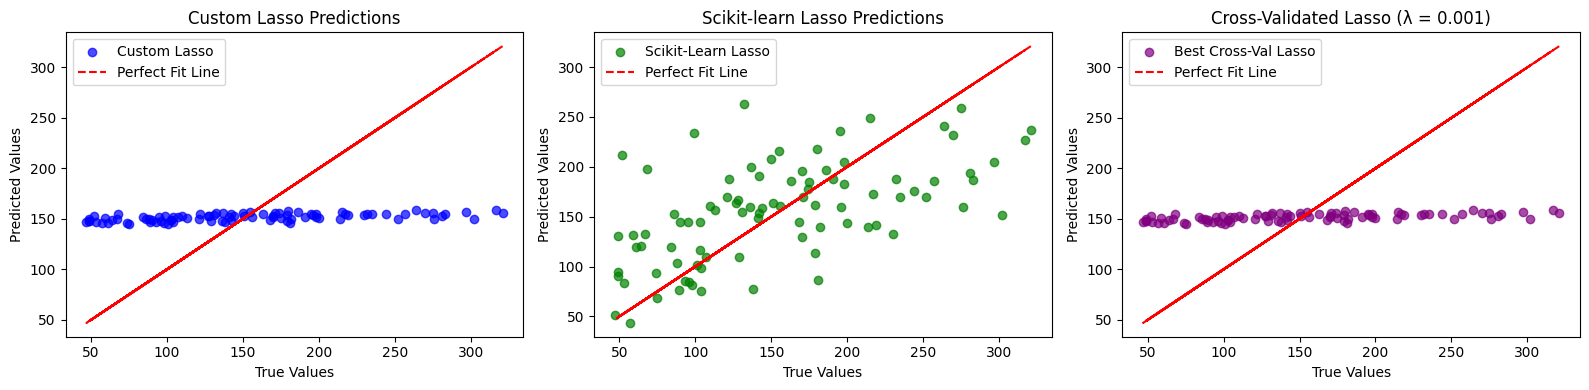

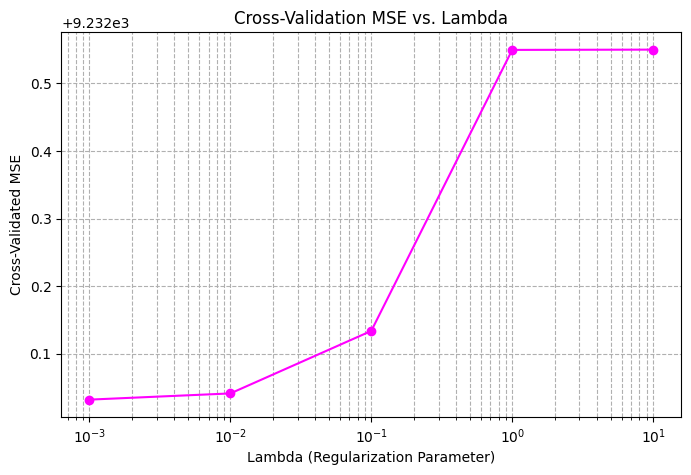

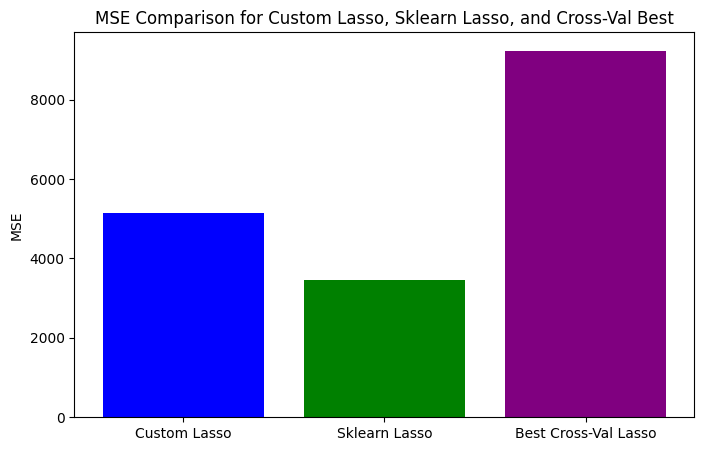

In [21]:
# --- Plot 1: Predictions vs. True Values ---
plt.figure(figsize=(16, 4))

# Custom Lasso Predictions
plt.subplot(1, 3, 1)
plt.scatter(y_test, final_custom_y_pred, color='blue',
            label='Custom Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Custom Lasso Predictions')
plt.legend()

# Scikit-learn Lasso Predictions
plt.subplot(1, 3, 2)
plt.scatter(y_test, final_sklearn_y_pred, color='green',
            label='Scikit-Learn Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scikit-learn Lasso Predictions')
plt.legend()

# Final Cross-Validated Lasso Predictions
plt.subplot(1, 3, 3)
plt.scatter(y_test, final_custom_y_pred, color='purple',
            label='Best Cross-Val Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Cross-Validated Lasso (λ = {best_lambda})')
plt.legend()

plt.tight_layout()
plt.show()

# --- Plot 2: MSE vs. Lambda ---
plt.figure(figsize=(8, 5))
plt.plot(list(lambda_mse_scores.keys()), list(
    lambda_mse_scores.values()), marker='o', color='magenta')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation MSE vs. Lambda')
plt.xscale('log')
plt.grid(True, linestyle='--', which='both')
plt.show()

# --- Plot 3: MSE Comparison (Custom vs. Sklearn vs. Cross-Val) ---
mse_values = [mse_custom, mse_sklearn, mse_cross_val_best]
mse_labels = ['Custom Lasso', 'Sklearn Lasso', 'Best Cross-Val Lasso']

plt.figure(figsize=(8, 5))
plt.bar(mse_labels, mse_values, color=['blue', 'green', 'purple'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom Lasso, Sklearn Lasso, and Cross-Val Best')
plt.show()

# ElasticNet

Implmentation

In [25]:
class elasticNet:
  def __init__(self, Lambda, Alpha,no_of_iterations,lr):
    self.Lambda = Lambda
    self.Alpha = Alpha
    self.no_of_iterations = no_of_iterations
    self.lr = lr
    self.shapeX = X_train.shape[0]
    self.shapeY = X_train.shape[1]

    self.w = np.zeros(self.shapeY)

    self.b = 0


  def weightUpdate(self):
    y_pred = self.predict(self.X_train)
    dW = np.zeros(self.shapeY) #initialized with zeros then will be updated based on no_of_iterations parameter
    for i in range(self.shapeY):
      if self.w[i]>0:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) ) + self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX
      else:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) )- self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX
      db = -2 * np.sum(self.Y_train - y_pred)/self.shapeX
      self.w = self.w - self.lr * dW
      self.b = self.b - self.lr * db

      return self
  def fit(self,X_train,Y_train):
    self.X_train = X_train

    self.Y_train = Y_train

    for i in range(self.no_of_iterations):
      self.weightUpdate()

    return self

  def predict(self,X_test):
    return X_test.dot(self.w) + self.b




Performance

In [26]:
mse_val = []
elastic = elasticNet(0.1,0.3, 500,0.1)
elastic.fit(X_train,y_train)
y_predict = elastic.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
mse_val.append(acc)
print(acc)

5069.658478041559


Performance for sklearn Model

In [27]:
elasticSklearn = ElasticNet(alpha=0.3,l1_ratio=0.1,max_iter=500)
elasticSklearn.fit(X_train,y_train)
y_predict = elasticSklearn.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
mse_val.append(acc)
print(acc)

5028.742771085206


Visualize

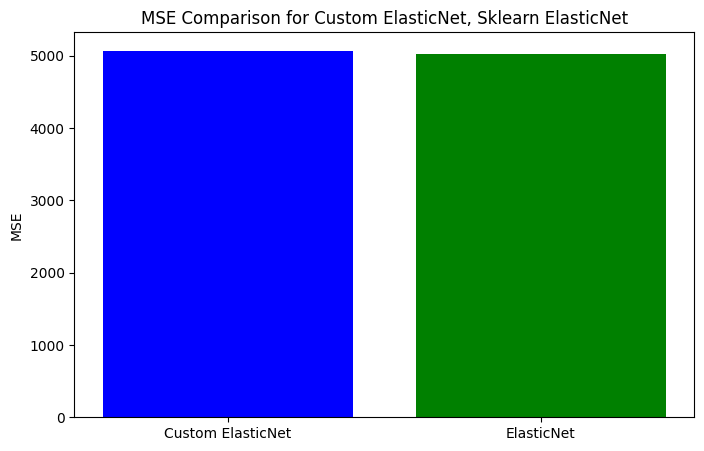

In [28]:
plt.figure(figsize=(8, 5))
plt.bar(['Custom ElasticNet','ElasticNet'], mse_val, color=['blue', 'green'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom ElasticNet, Sklearn ElasticNet')
plt.show()

# DataSet2

Loading Defining Features and Target

In [46]:
X, y = make_regression(n_samples=1000, n_features=8)

Data Splitting for Testing and Training

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=0)

# Ridge

Implmentation

In [31]:
class RidgeRegression:
    def __init__(self, regulizer=1.0):
        self.regulizer = regulizer  # Regularization strength
        self.coffs = None  # Model Weights
        self.b = None  # b term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        X_augmented = np.hstack([np.ones((n_samples, 1)), X])    # Augmentation (1's Column)

        I = np.eye(X_augmented.shape[1])
        I[0, 0] = 0  # for not regulizing b

        XtX = np.dot(X_augmented.T, X_augmented)  # XT * X
        XtY = np.dot(X_augmented.T, y)  # XT * y

        XtX_reg = XtX + self.regulizer * I      # XTX+λI

        XtX_reg_inv = np.linalg.inv(XtX_reg)    # (XTX+λI)^−1
        coffs = np.dot(XtX_reg_inv, XtY)        # W=(XTX+λI)^−1 XTy

        self.b = coffs[0]  # The first value is the b
        self.coffs = coffs[1:]  # The rest are the Weights


    def predict(self, X):
        #------np.dot(----------------Augmented X--------,-------b added to W in one vecto----)----
        return np.dot(np.hstack([np.ones((X.shape[0], 1)), X]), np.hstack([self.b, self.coffs]))   #y^=X⋅W




Performance

In [32]:
ridge_custom = RidgeRegression(regulizer=1.0)
ridge_custom.fit(X_train, y_train)

y_pred_custom = ridge_custom.predict(X_test)
mse_custom = mean_squared_error(y_test, y_pred_custom)
print("Custom Ridge Regression MSE:", mse_custom)

ridge_sklearn = Ridge(alpha=1.0)
ridge_sklearn.fit(X_train, y_train)
y_pred_sklearn = ridge_sklearn.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
print("Scikit-learn Ridge Regression MSE:", mse_sklearn)

print("Custom Coefficients:", ridge_custom.coffs)
print("Scikit-learn Coefficients:", ridge_sklearn.coef_)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_custom_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_custom = RidgeRegression(regulizer=1.0)
    ridge_custom.fit(X_train, y_train)
    y_pred_custom = ridge_custom.predict(X_test)

    mse_custom = mean_squared_error(y_test, y_pred_custom)
    mse_custom_scores.append(mse_custom)

mean_mse_custom = np.mean(mse_custom_scores)

print("Custom Ridge Regression Mean MSE with Cross-Validation:", mean_mse_custom)


Custom Ridge Regression MSE: 0.04577584246118413
Scikit-learn Ridge Regression MSE: 0.04577584246116986
Custom Coefficients: [ 5.27700872 59.29531834 63.36824165 81.62623464 48.89791462 29.58151125
 87.6270921  56.38372059]
Scikit-learn Coefficients: [ 5.27700872 59.29531834 63.36824165 81.62623464 48.89791462 29.58151125
 87.6270921  56.38372059]
Custom Ridge Regression Mean MSE with Cross-Validation: 0.046666325527746175


Performance for sklearn Model

In [33]:
mse_sklearn_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_sklearn = Ridge(alpha=1.0)
    ridge_sklearn.fit(X_train, y_train)
    y_pred_sklearn = ridge_sklearn.predict(X_test)

    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    mse_sklearn_scores.append(mse_sklearn)

mean_mse_sklearn = np.mean(mse_sklearn_scores)
print("Scikit-learn Ridge Regression Mean MSE with Cross-Validation:", mean_mse_sklearn)

Scikit-learn Ridge Regression Mean MSE with Cross-Validation: 0.046666325527742025


Visualize

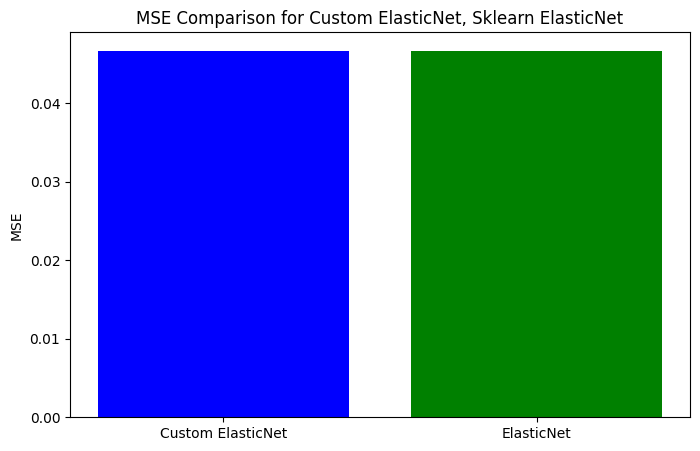

In [34]:
plt.figure(figsize=(8, 5))
plt.bar(['Custom ElasticNet','ElasticNet'], [mean_mse_custom,mean_mse_sklearn], color=['blue', 'green'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom ElasticNet, Sklearn ElasticNet')
plt.show()

# Lasso

Implementation

In [37]:
class LassoRegression:
    """
    Lasso Regression using L1 regularization.
    """

    class l1_regularization:
        """L1 Regularization for Lasso Regression"""

        def __init__(self, lamda):
            self.lamda = lamda

        def __call__(self, w):
            """L1 regularization term."""
            return self.lamda * np.sum(np.abs(w))

        def derivation(self, w):
            """Derivative of L1 regularization."""
            return self.lamda * np.sign(w)

    def __init__(self, lamda=0.01, lr=0.01, itr=1000, tolerance=1e-6):
        """
        lamda: Regularization factor
        lr: Learning rate
        itr: Maximum number of iterations
        tolerance: Convergence threshold for cost change
        """
        self.regularization = self.l1_regularization(lamda)
        self.lr = lr
        self.itr = itr
        self.tolerance = tolerance
        self.m = None  # number of training samples
        self.n = None  # number of features
        self.w = None  # weights
        self.b = None  # bias

    def cost_function(self, y, y_pred):
        """Calculate the cost function J(w) with L1 regularization."""
        mse = (1 / (2 * self.m)) * np.sum(np.square(y_pred - y))
        reg_term = self.regularization(self.w)
        return mse + reg_term

    def hypothesis(self, w, b, X):
        """Predict target values using the linear hypothesis."""
        return np.dot(X, w) + b

    def train(self, X, y):
        """Train the model using gradient descent."""

        # Ensure y is a column vector (n, 1)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        self.m, self.n = X.shape

        if self.m == 0:
            raise ValueError(
                "Number of training samples (m) is zero, which will cause division by zero.")

        # Initialize weights and bias
        self.w = np.zeros((self.n, 1))
        self.b = 0

        previous_cost = float('inf')  # To check convergence

        for it in range(1, self.itr + 1):
            # 1. Calculate predictions
            y_pred = self.hypothesis(self.w, self.b, X)

            # 2. Calculate the cost
            cost = self.cost_function(y, y_pred)

            # 3. Calculate gradients for w and b
            dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
            # L1 regularization on weights only (exclude bias)
            dw += self.regularization.derivation(self.w)

            db = (1 / self.m) * np.sum(y_pred - y)  # Gradient for the bias

            # 4. Update weights and bias using gradient descent
            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db

            # 5. Convergence check
            # if abs(previous_cost - cost) < self.tolerance:
            #     logging.info(f"Convergence reached at iteration {it} with cost {cost:.6f}")
            #     break

            previous_cost = cost

            # Logging for every 100 iterations
            # if it % 100 == 0:
            #     logging.info(f"Iteration {it} | Cost: {cost:.6f}")

    def predict(self, X):
        """Predict the target values for the given input features."""
        y_pred = self.hypothesis(self.w, self.b, X)
        return y_pred

Y to 1-D instaed of 2-D

In [38]:
Y = y[:, np.newaxis]
print("="*100)
print("Number of training data samples-----> {}".format(X.shape[0]))
print("Number of training features --------> {}".format(X.shape[1]))
print("Shape of the target value ----------> {}".format(y.shape))

Number of training data samples-----> 1000
Number of training features --------> 8
Shape of the target value ----------> (1000,)


Performance of custom Lasso

In [39]:
lasso_model = LassoRegression(lamda=1, lr=0.01, itr=1000)
lasso_model.train(X_train, y_train)
y_pred = lasso_model.predict(X_test)
print(y_pred.flatten())

[-1.78594287e+01  6.38810044e+01 -3.65956222e+01  1.84891730e+02
 -1.79435625e+02 -2.55425359e+01 -8.41473097e+01  6.76954898e+01
 -1.31815978e+02 -1.74800107e+02  2.45455257e+00  8.16691319e+01
  1.96263557e+02 -5.57356772e+01  2.60812952e+02  1.25473900e+02
  1.89641524e+01 -1.84267433e+02 -1.58863766e+02  2.22450822e+02
  1.24920388e+02  9.05647691e+01 -2.79129561e+01  2.29135975e+00
 -8.56319196e+01 -1.15570914e+02 -3.26760040e+01  1.70257633e+02
 -8.61790972e+01 -9.21293583e+01  2.73667865e+01 -1.31854412e+02
 -1.10653164e+02 -2.15310365e+01  4.08354454e+01 -1.03986273e+02
  9.04959023e+01  6.30884520e+01  8.27969903e+01 -2.20480724e+01
  2.04679016e+01  4.00218041e+00  8.35829064e+01 -1.29917035e+02
 -1.18467152e+02 -2.45824720e+02 -7.51321619e+01 -8.01972968e+01
 -9.83995847e+01  1.65802640e+02 -2.10234974e+02  5.60729179e+00
 -1.26162227e+02  1.51296921e+01 -1.74097819e+02  9.56331789e+01
  3.01618056e+01  2.33209679e+02  3.16920926e+01 -1.20457289e+00
  8.03334401e+01  2.30604

In [40]:
model = Lasso(alpha=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[-1.78839338e+01  6.38727710e+01 -3.66065419e+01  1.84901884e+02
 -1.79445208e+02 -2.55481533e+01 -8.41582199e+01  6.77068688e+01
 -1.31840112e+02 -1.74827181e+02  2.46273413e+00  8.16782573e+01
  1.96285367e+02 -5.57393656e+01  2.60824699e+02  1.25492040e+02
  1.89584690e+01 -1.84286000e+02 -1.58881281e+02  2.22474799e+02
  1.24928264e+02  9.05698921e+01 -2.79191172e+01  2.28877625e+00
 -8.56452679e+01 -1.15587730e+02 -3.27058256e+01  1.70272350e+02
 -8.61892714e+01 -9.21148234e+01  2.73845682e+01 -1.31875175e+02
 -1.10653911e+02 -2.15306379e+01  4.08604735e+01 -1.04008521e+02
  9.05084328e+01  6.30936480e+01  8.27898846e+01 -2.20630524e+01
  2.04653872e+01  3.99987071e+00  8.35785379e+01 -1.29934450e+02
 -1.18490999e+02 -2.45851499e+02 -7.51407899e+01 -8.02002450e+01
 -9.84029228e+01  1.65813252e+02 -2.10236515e+02  5.58367109e+00
 -1.26172209e+02  1.51355119e+01 -1.74111535e+02  9.56378165e+01
  3.01624074e+01  2.33240458e+02  3.16895135e+01 -1.19949122e+00
  8.03546238e+01  2.30626

Testing diffrent lambdas

In [41]:
lambdas = [0.001, 0.01, 0.1, 1, 10]
k_folds = 10 # Number of folds for cross-validation
lambda_mse_scores = {}

for lamda in lambdas:
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = LassoRegression(lamda=lamda, lr=0.01, itr=100)
        model.train(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        mse = np.mean((y_val_pred - y_val_fold) ** 2)
        mse_scores.append(mse)

    lambda_mse_scores[lamda] = np.mean(mse_scores)

best_lambda = min(lambda_mse_scores, key=lambda x: lambda_mse_scores[x])
print(f"Best Lambda from Cross-Validation: {best_lambda}")

Best Lambda from Cross-Validation: 10


Fitting with the est fucking lambda

In [42]:
# Train the final custom Lasso model with the best lambda
final_custom_model = LassoRegression(lamda=best_lambda, lr=0.01, itr=1000)
final_custom_model.train(X_train, y_train)
final_custom_y_pred = final_custom_model.predict(X_test)
print(final_custom_y_pred.flatten())

[  -5.75412986   51.45432323  -25.23859959  145.43544036 -163.26048599
  -37.35665426  -78.84192962   44.86753882  -79.89180303 -144.60620792
   15.18785029   57.5103483   140.25710787  -41.70743601  216.91136088
   94.89773441   18.9117347  -154.40335944 -140.74227738  194.36357536
  100.28599822   83.66401868  -16.66777801  -10.89153735  -61.87556902
  -65.65013066   20.26128355  137.50711458  -60.43649287  -75.59134823
   15.19969518 -103.43226291  -86.42814332  -10.75379934   23.77146532
  -98.95799031   61.32076131   47.39079455   76.41933716  -10.30100594
   10.6325475    27.5120692    70.52926845 -117.59544181 -119.36021768
 -218.77932219  -45.04177621  -87.23867092  -77.60831886  135.05990199
 -180.14560697   10.53336679  -82.62011233    7.56878225 -131.48121199
   61.68896035   36.1836887   197.97260496   30.06230002   -7.83260911
   53.85426742  195.03074015  -16.70515267 -128.94628227  -18.1623327
  -94.92531242  205.58936508  -33.64458684  -27.09265219  -41.84438919
   89.2

Scikitlearn Model Performance

In [43]:
# --- Scikit-learn Lasso Model with Cross-Validation ---
param_grid = {'alpha': lambdas}
grid_search = GridSearchCV(
    Lasso(max_iter=1000), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha from Scikit-learn GridSearchCV: {best_alpha}")


final_sklearn_model = Lasso(alpha=best_alpha, max_iter=1000)
final_sklearn_model.fit(X_train, y_train)
final_sklearn_y_pred = final_sklearn_model.predict(X_test)

Best Alpha from Scikit-learn GridSearchCV: 0.001


MSEs for the two models

In [44]:
mse_custom = np.mean((final_custom_y_pred - y_test) ** 2)
mse_sklearn = np.mean((final_sklearn_y_pred - y_test) ** 2)
mse_cross_val_best = lambda_mse_scores[best_lambda]

print(f"MSE (Custom Lasso): {mse_custom}")
print(f"MSE (Scikit-learn Lasso): {mse_sklearn}")
print(f"MSE (Cross-Validated Best Lambda): {mse_cross_val_best}")

MSE (Custom Lasso): 18226.469784841916
MSE (Scikit-learn Lasso): 8.435338530064339e-06
MSE (Cross-Validated Best Lambda): 14273.531074073439


Visualize

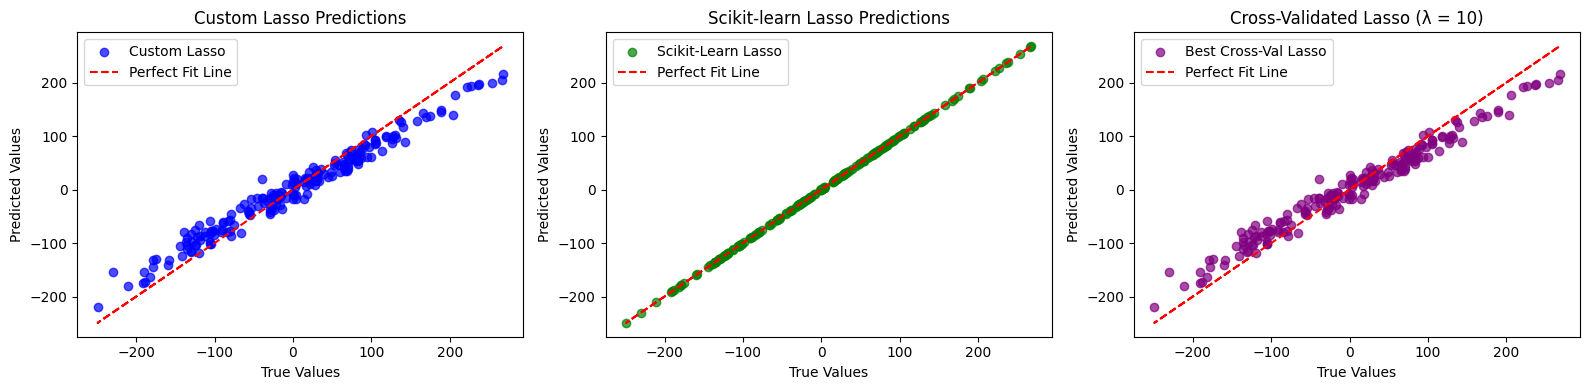

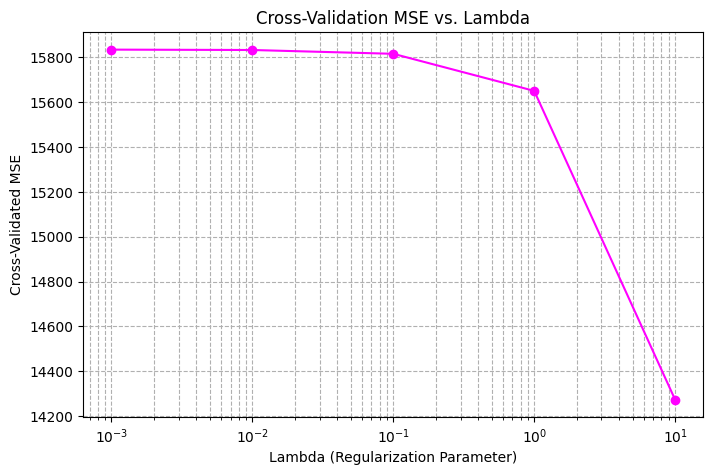

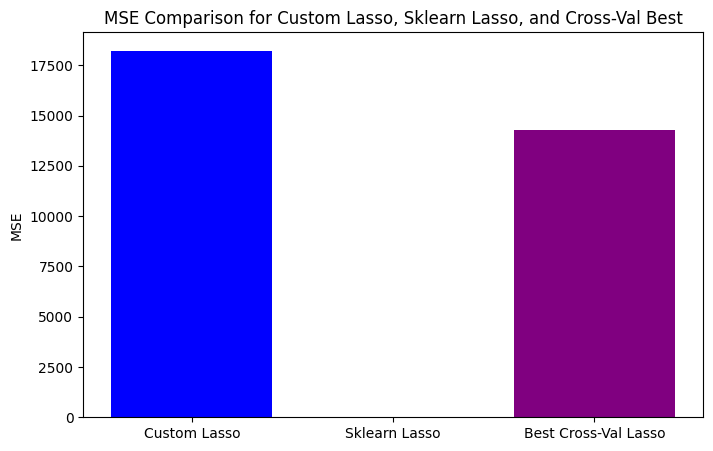

In [45]:
# --- Plot 1: Predictions vs. True Values ---
plt.figure(figsize=(16, 4))

# Custom Lasso Predictions
plt.subplot(1, 3, 1)
plt.scatter(y_test, final_custom_y_pred, color='blue',
            label='Custom Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Custom Lasso Predictions')
plt.legend()

# Scikit-learn Lasso Predictions
plt.subplot(1, 3, 2)
plt.scatter(y_test, final_sklearn_y_pred, color='green',
            label='Scikit-Learn Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scikit-learn Lasso Predictions')
plt.legend()

# Final Cross-Validated Lasso Predictions
plt.subplot(1, 3, 3)
plt.scatter(y_test, final_custom_y_pred, color='purple',
            label='Best Cross-Val Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Cross-Validated Lasso (λ = {best_lambda})')
plt.legend()

plt.tight_layout()
plt.show()

# --- Plot 2: MSE vs. Lambda ---
plt.figure(figsize=(8, 5))
plt.plot(list(lambda_mse_scores.keys()), list(
    lambda_mse_scores.values()), marker='o', color='magenta')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation MSE vs. Lambda')
plt.xscale('log')
plt.grid(True, linestyle='--', which='both')
plt.show()

# --- Plot 3: MSE Comparison (Custom vs. Sklearn vs. Cross-Val) ---
mse_values = [mse_custom, mse_sklearn, mse_cross_val_best]
mse_labels = ['Custom Lasso', 'Sklearn Lasso', 'Best Cross-Val Lasso']

plt.figure(figsize=(8, 5))
plt.bar(mse_labels, mse_values, color=['blue', 'green', 'purple'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom Lasso, Sklearn Lasso, and Cross-Val Best')
plt.show()

# ElasticNet

Implmentation

In [48]:
class elasticNet:
  def __init__(self, Lambda, Alpha,no_of_iterations,lr):
    self.Lambda = Lambda
    self.Alpha = Alpha
    self.no_of_iterations = no_of_iterations
    self.lr = lr
    self.shapeX = X_train.shape[0]
    self.shapeY = X_train.shape[1]

    self.w = np.zeros(self.shapeY)

    self.b = 0


  def weightUpdate(self):
    y_pred = self.predict(self.X_train)
    dW = np.zeros(self.shapeY) #initialized with zeros then will be updated based on no_of_iterations parameter
    for i in range(self.shapeY):
      if self.w[i]>0:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) ) + self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX
      else:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) )- self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX
      db = -2 * np.sum(self.Y_train - y_pred)/self.shapeX
      self.w = self.w - self.lr * dW
      self.b = self.b - self.lr * db

      return self
  def fit(self,X_train,Y_train):
    self.X_train = X_train

    self.Y_train = Y_train

    for i in range(self.no_of_iterations):
      self.weightUpdate()

    return self

  def predict(self,X_test):
    return X_test.dot(self.w) + self.b




Performance

In [49]:
mse_val = []
elastic = elasticNet(0.1,0.3, 1000,0.1)
elastic.fit(X_train,y_train)
y_predict = elastic.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
mse_val.append(acc)
print(acc)

23039.221635726597


Performance for sklearn Model

In [50]:
elasticSklearn = ElasticNet(alpha=0.3,l1_ratio=0.1,max_iter=500)
elasticSklearn.fit(X_train,y_train)
y_predict = elasticSklearn.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
mse_val.append(acc)
print(acc)

1329.7261510086205


Visualize

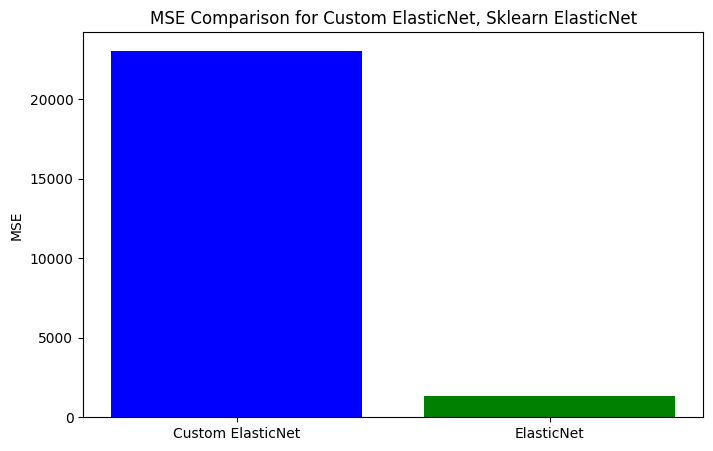

In [51]:
plt.figure(figsize=(8, 5))
plt.bar(['Custom ElasticNet','ElasticNet'], mse_val, color=['blue', 'green'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom ElasticNet, Sklearn ElasticNet')
plt.show()